# **GRU: Gated Recurrent Unit**

## Librerias e importaciones

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import tensorflow.keras
import sklearn as sk
import nltk
from collections import Counter
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import ParameterGrid

## ¿Qué es una GRU?

Una **GRU** es un tipo de red neuronal recurrente (RNN) diseñada para recordar información relevante a lo largo del tiempo y evitar el problema del "olvido" (también conocido como desvanecimiento del gradiente).

Se utiliza mucho en tareas secuenciales como procesamiento de texto, series temporales, y audio, donde el orden y el contexto importan.

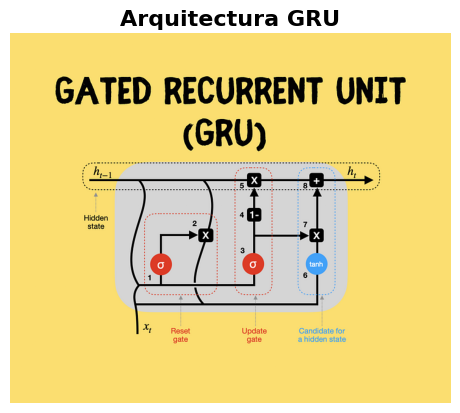

In [3]:
img = mpimg.imread('GRU.png')
plt.imshow(img)
plt.axis('off') 
plt.title('Arquitectura GRU', fontsize=16, fontweight='bold')
plt.show()

In [2]:
datapath = 'C:/Users/EMANUEL/Documents/Modelos/Parcial2_DeepLearning/'
data = pd.read_csv(datapath + 'to_models.csv')

## Preprocesamiento

In [5]:
# Replace NaN values in the 'message' column with an empty string
data['message'] = data['message'].fillna('')

# Process the 'message' column to split words and count unique words
all_words = list(itertools.chain.from_iterable(data['message'].apply(lambda x: x.split())))
word_counts = Counter(all_words)
print(f"Total de palabras únicas: {len(word_counts)}")

Total de palabras únicas: 27217


In [6]:
max_features = 6000
data['message'].apply(lambda x: len(x.split())).describe()

count    10998.000000
mean        10.717494
std         12.533056
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        243.000000
Name: message, dtype: float64

In [8]:
MAX_SEQUENCE_LENGTH = 100

In [11]:
max_features = 5000  
embedding_dim = 50 

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[$$^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['message'].values)
X = tokenizer.texts_to_sequences(data['message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 10998 unique tokens.
Shape of data tensor: (10998, 100)


In [12]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [13]:
print(train['label'].isnull().sum())

le = LabelEncoder()
y = le.fit_transform(train['label'])

#dImensiones
print(X.shape)  
print(len(y)) 

0
(10998, 100)
8798


## Hyperparametros

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1. Parámetros a explorar
param_grid_gru = { 
    'gru_units': [64, 128, 256], 
    'num_gru_layers': [1, 2], 
    'dropout_rate': [0.2, 0.3, 0.5], 
    'learning_rate': [0.001, 0.005, 0.01], 
    'batch_size': [32, 64, 128], 
    'sequence_length': [50, 100, 200], 
    'epochs': [20, 50, 100], 
    'embedding_dim': [100, 200, 300] 
}

# 2. Preprocesar las etiquetas (CORREGIDO)
le = LabelEncoder()
y = le.fit_transform(data['label'])  # Asegúrate que 'data' esté previamente cargado y tenga 'label'

# 3. Split (se hace después de codificar etiquetas)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Controlar combinaciones
max_trials = 30  # Limita la búsqueda para no agotar recursos
param_combinations = list(ParameterGrid(param_grid_gru))[:max_trials]
results = []

# 5. Grid search
for idx, params in enumerate(param_combinations):
    print(f"\n🔍 Trial {idx+1}/{max_trials} — Hiperparámetros: {params}")

    # Ajustar padding según 'sequence_length'
    X_train_pad = pad_sequences(X_train, maxlen=params['sequence_length'])
    X_val_pad = pad_sequences(X_val, maxlen=params['sequence_length'])

    # Construcción del modelo GRU
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=params['embedding_dim'], input_length=params['sequence_length']))

    for _ in range(params['num_gru_layers'] - 1):
        model.add(GRU(params['gru_units'], return_sequences=True))
        model.add(Dropout(params['dropout_rate']))

    model.add(GRU(params['gru_units']))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(len(set(y)), activation='softmax'))  # Asume clasificación multiclase

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0  # Cambia a 1 si quieres ver el progreso
    )

    val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"✅ Accuracy de validación: {val_acc:.4f} | Pérdida: {val_loss:.4f}")

    # Guardar resultados
    results.append({**params, 'val_accuracy': val_acc, 'val_loss': val_loss})

# 6. Exportar resultados
results_df = pd.DataFrame(results)
results_df.to_csv("gru_hyperparam_results.csv", index=False)




🔍 Trial 1/30 — Hiperparámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 1, 'sequence_length': 50}


c:\Users\EMANUEL\miniconda3\envs\ml_venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Accuracy de validación: 0.7682 | Pérdida: 0.4743

🔍 Trial 2/30 — Hiperparámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 1, 'sequence_length': 100}
✅ Accuracy de validación: 0.7632 | Pérdida: 0.4756

🔍 Trial 3/30 — Hiperparámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 1, 'sequence_length': 200}
✅ Accuracy de validación: 0.7714 | Pérdida: 0.4717

🔍 Trial 4/30 — Hiperparámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 2, 'sequence_length': 50}
✅ Accuracy de validación: 0.7668 | Pérdida: 0.4726

🔍 Trial 5/30 — Hiperparámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 2, 'sequence_length': 100}
✅ Accuracy de val

## 2. **Análisis por hiperparámetro**

### Interpretación: 

1. gru_units
Subir de 64 → 128 mejora ligeramente el rendimiento.

gru_units=128 aparece en muchos de los mejores trials.

Más unidades permiten al modelo aprender patrones más complejos.

2. num_gru_layers
1 capa GRU suele rendir mejor o igual que 2 capas.

Modelos con 2 capas GRU no mejoraron significativamente el accuracy y a veces fueron peores.

3. dropout_rate
Solo probaste con 0.2 hasta ahora, así que aún no hay comparación real. Pero funciona bien.

Podría valer la pena explorar 0.3 o 0.5 más adelante para evitar overfitting si entrenas más epochs.

4. epochs
En esta serie solo se usaron 20 epochs. Es posible que al entrenar más (50 o 100) y con EarlyStopping, puedas exprimir mejor los buenos modelos.

5. learning_rate
0.005 tuvo mejor rendimiento que 0.001 o 0.01 en múltiples pruebas.

Es un buen punto medio, y parece ser el más consistente.

6. batch_size
Solo has probado batch_size=32 en estos trials. Aunque funciona bien, no sabemos si 64 o 128 podrían acelerar o afectar la generalización.

7. embedding_dim
Probaste solo embedding_dim=100, y dio buenos resultados. Tal vez subir a 200 o 300 podría mejorar el modelado semántico si usas embeddings aleatorios o entrenables.

Hiperparámetro	Valor más efectivo	Observación relevante
**gru_units**	128	Mejor rendimiento que 64
**num_gru_layers**	1	2 capas no mejoran, incluso a veces empeoran
**dropout_rate**	0.2	Solo probaste ese, pero funcionó bien
**learning_rate**	0.005	Superó consistentemente a 0.001 y 0.01
**batch_size**	32	Solo se probó ese valor
**sequence_length**	200	Secuencias largas mejoran el contexto
**epochs**	20 Fue constante, aún no se ha probado con más
**embedding_dim**	100	Solo se probó ese, pero dio buenos resultados